In [1]:
import pandas as pd
import numpy as np
import itertools as it

import pickle as pcl

from scipy.spatial.distance import cdist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from collections import Counter

# Get "Set2" colors from ColorBrewer (all colorbrewer scales: http://bl.ocks.org/mbostock/5577023)
#set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import MeanShift

In [2]:
from palettable.tableau import GreenOrange_12
from palettable.colorbrewer.sequential import YlGnBu_4, YlGnBu_5

cmap = GreenOrange_12.hex_colors
cmap_seq = YlGnBu_5.hex_colors

In [3]:
import hightolowz

In [4]:
redshift = '3p95' # '5p03'
redshift_str = '3.95' # '5.03'
selection = 'sfr'

In [5]:
dgal_random_r20 = pd.read_csv('data/r200/dgal_%s_%s_r20_random.csv' % (selection, redshift))
dgal_random_r12p5 = pd.read_csv('data/r200/dgal_%s_%s_r12.5_random.csv' % (selection, redshift))
dgal_random_r7p5 = pd.read_csv('data/r200/dgal_%s_%s_r7.5_random.csv' % (selection, redshift))
dgal_random_r5 = pd.read_csv('data/r200/dgal_%s_%s_r5_random.csv' % (selection, redshift))

In [7]:
dgal_random = pd.concat([dgal_random_r20,dgal_random_r12p5,dgal_random_r7p5,dgal_random_r5], axis=1)

### Probability distribution

For each sampled region if over 50% of the galaxies end up in a cluster sized object at $z=0$ we classify it as a protocluster. We then find the fraction of protoclusters for a range of binned overdensities

In [29]:
def aggregate_dgal(df, R, bins, lim_frac, lim_mass=1e4):
    """
    Aggregate galaxy overdensity information
    """

    agg_data = pd.DataFrame([bins]).T
    
    agg_data.columns = ['bins']

    agg_data['total'] = pd.DataFrame(np.histogram(df['delta_gal_%s' % str(R)], bins)[0])

    agg_data['frac'] =  pd.DataFrame(np.histogram(df[(df['max_fraction_%s' % str(R)] > lim_frac) \
                             & (df['max_fraction_mass_%s' % str(R)] > lim_mass)]['delta_gal_%s' % str(R)], bins)[0])

    agg_data['frac'] /= agg_data['total']

    agg_data['n_cluster_desc'] = pd.DataFrame(np.histogram(df[(df['max_fraction_%s' % str(R)] < lim_frac) \
                                    & (df['n_cluster_desc_%s' % str(R)] > 0)]['delta_gal_%s' % str(R)], bins)[0])

    agg_data['n_cluster_desc'] /= agg_data['total']

    return agg_data

Probability distribution and PDF of protocluster regions and non-protocluster regions

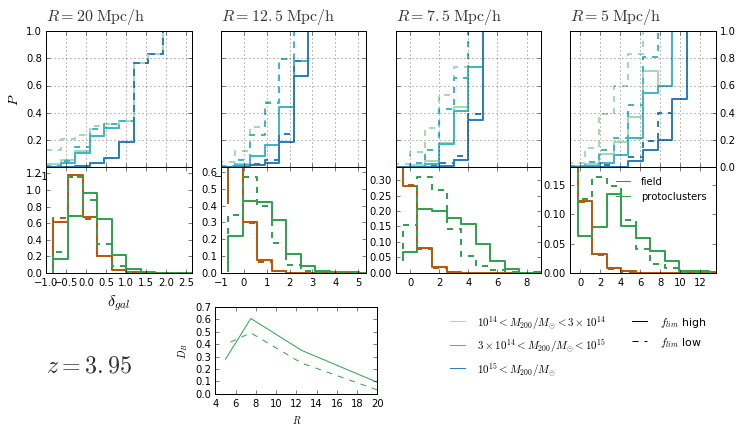

In [32]:
fig = plt.figure(figsize=(12,6.5))

gs1 = gridspec.GridSpec(24, 4)

gs1.update(hspace=0.)#, wspace=0) bottom = 0.57, top = 1, 

ax1 = fig.add_subplot(gs1[:9,0])
ax2 = fig.add_subplot(gs1[:9,1])
ax3 = fig.add_subplot(gs1[:9,2])
ax4 = fig.add_subplot(gs1[:9,3])

ax5 = fig.add_subplot(gs1[9:16,0])
ax6 = fig.add_subplot(gs1[9:16,1])
ax7 = fig.add_subplot(gs1[9:16,2])
ax8 = fig.add_subplot(gs1[9:16,3])

gs2 = gridspec.GridSpec(12, 16)
#gs2.update(bottom = 0.57, top = 1, hspace=0)#, wspace=0)

ax9 = fig.add_subplot(gs2[9:12, 4:8])

Bhatta = []
Bhatta_relaxed = []

redshift_str = '3.95'
redshift = '3p95'

ax5.text(0, -1.5, "$z = %s$" % redshift_str, transform = ax1.transAxes, size=24, alpha=0.8)

N = 12

for R, ax_up, ax_dw, limiting_fraction, limiting_fraction_relaxed in zip(['20', '12.5', '7.5', '5'], 
                                                                         [ax1, ax2, ax3, ax4], 
                                                                         [ax5, ax6, ax7, ax8], 
                                                                         [0.20, 0.55, 0.85, 0.95],
                                                                         [0.10, 0.40, 0.70, 0.80]):


    ax_up.text(0, 1.08, "$R = %s \; \mathrm{Mpc / h}$" % R, transform = ax_up.transAxes, size=16, alpha=0.8)

    dgal_max = max(dgal_random['delta_gal_%s'%R])   

    binLimits = np.linspace(-1, int(dgal_max)+1, N)

    lower_bin = binLimits[1] + (binLimits[0]-binLimits[1])/2 
    upper_bin = binLimits[-1] + (binLimits[0]-binLimits[1])/2

    bins = np.linspace(lower_bin, upper_bin, N-1)

    agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction, lim_mass=1e4)
    agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
    ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[1], linewidth=2)
    
    agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction, lim_mass=3e4)
    agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
    ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[2], linewidth=2)

    agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction, lim_mass=1e5)
    agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
    ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[3], linewidth=2)

    # relaxed limiting fraction
    agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction_relaxed, lim_mass=1e4)
    agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
    ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[1], linestyle='dashed', linewidth=2)

    agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction_relaxed, lim_mass=3e4)
    agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
    ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[2], linestyle='dashed', linewidth=2)

    agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction_relaxed, lim_mass=1e5)
    agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
    ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[3], linestyle='dashed', linewidth=2)


#     phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] >= limiting_fraction) \
#                               & (dgal_random['max_fraction_mass_%s'%R] >= 1e4) \
#                               & (dgal_random['max_fraction_mass_%s'%R] < 3e4)]['delta_gal_%s'%R],
#                               bins=binLimits, normed=True)
#     ax_dw.step(bins, phiA, color=cmap_seq[1])
#     max_phi = max(phiA)

#     phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] >= limiting_fraction) \
#                               & (dgal_random['max_fraction_mass_%s'%R] >= 3e4) \
#                               & (dgal_random['max_fraction_mass_%s'%R] < 1e5)]['delta_gal_%s'%R],
#                               bins=binLimits, normed=True)
#     ax_dw.step(bins, phiA, color=cmap_seq[2])
#     max_phi = max(max_phi, max(phiA))

#     phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] >= limiting_fraction) \
#                               & (dgal_random['max_fraction_mass_%s'%R] >= 1e5)]['delta_gal_%s'%R],
#                               bins=binLimits, normed=True)
#     ax_dw.step(bins, phiA, color=cmap_seq[3])
#     max_phi = max(max_phi, max(phiA))

    for lfrac, bat, ls in zip([limiting_fraction, limiting_fraction_relaxed],[Bhatta, Bhatta_relaxed],['solid','dashed']):
        phiB, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] < lfrac) \
                                  | (dgal_random['max_fraction_mass_%s'%R] < 1e4)]['delta_gal_%s'%R],
                                  bins=binLimits, normed=True)
        ax_dw.step(bins, phiB, color=cmap[6], linewidth=2, linestyle=ls)

        phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] >= lfrac) \
                                  & (dgal_random['max_fraction_mass_%s'%R] >= 1e4)]['delta_gal_%s'%R],
                                  bins=binLimits, normed=True)
        ax_dw.step(bins, phiA, color=cmap[0], linewidth=2, linestyle=ls)
        max_phi = max(phiA)

        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))

        # ax_dw.text(0.64, 0.7, "$D_{B} = %.2f$" % DB, transform = ax_dw.transAxes)
        bat.append(DB)

#     if i == 0:
#         ax_up.text(0.05, 1.25, "$R=%s \, Mpc/h$" % str(round(float(R), 1)), transform = ax_up.transAxes)
#         ax_up.text(0.05, 1.1, "$f_{lim}=$ %.2f / %.2f" % (limiting_fraction, limiting_fraction_relaxed), transform = ax_up.transAxes)

    ax_up.grid()

    # ax_up.set_xlim(min(binLimits), max(binLimits))

    ax_dw.set_ylim(0, max_phi + max_phi/10)
    ax_dw.set_xlim(min(bins) - (bins[1]-bins[0])/2, max(bins) - (bins[1]-bins[0])/2)
    ax_up.set_xlim(min(bins) - (bins[1]-bins[0])/2, max(bins) - (bins[1]-bins[0])/2)

    
    
    
ax9.plot([20,12.5,7.5,5], Bhatta, color=cmap[0])
ax9.plot([20,12.5,7.5,5], Bhatta_relaxed, color=cmap[0], linestyle='dashed')
    
ax9.set_xlabel('$R$')
ax9.set_ylabel('$D_{B}$')
#ax9.vlines(7.5, 0, 0.7, colors='grey', linestyles='dotted')
    

ax5.set_xlabel('$\delta_{gal}$', size=16)
ax1.set_ylabel('$P$', size=14)
ax1.set_yticklabels(['','0.2','0.4','0.6','0.8','1.0'])


# for ax in [ax1, ax2, ax3, ax4]:
#     ax.set_xticklabels('')

for ax in [ax2, ax3]:
    ax.set_yticklabels('')
    
ax4.yaxis.tick_right()
    
line_field = plt.Line2D((0,1.5),(0,0), color=cmap[6], linestyle='solid', linewidth=1)
line_protocluster = plt.Line2D((0,1.5),(0,0), color=cmap[0], linestyle='solid', linewidth=1)
    
ax8.legend(handles=[line_field, line_protocluster], labels=['field', 'protoclusters'], prop={'size':10}, bbox_to_anchor=(1, 1), frameon=False)

line_small = plt.Line2D((0,1.5),(0,0), color=cmap_seq[1], linestyle='solid', linewidth=1)
line_medium = plt.Line2D((0,1.5),(0,0), color=cmap_seq[2], linestyle='solid', linewidth=1)
line_large = plt.Line2D((0,1.5),(0,0), color=cmap_seq[3], linestyle='solid', linewidth=1)

line_frac_hi = plt.Line2D((0,1.5),(0,0), color='black', linestyle='solid', linewidth=1)
line_frac_lo = plt.Line2D((0,1.5),(0,0), color='black', linestyle='dashed', linewidth=1)

ax3.legend(handles=[line_small, line_medium, line_large, line_frac_hi, line_frac_lo],
           labels=['$10^{14} < M_{200} / M_{\odot} < 3 \\times 10^{14}$','$3 \\times 10^{14} < M_{200} / M_{\odot} < 10^{15}$',
                   '$10^{15} < M_{200} / M_{\odot}$','$f_{lim}$ high','$f_{lim}$ low'], 
           prop={'size':11}, bbox_to_anchor=(2.2, -1), frameon=False, ncol=2)

# plt.savefig('../papers/hightolowz/images/gal_od_prob_%s_%s_single.png' % (redshift, selection), bbox_inches='tight', dpi=300)

### Test

In [1]:
import timeit

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from collections import Counter

from mpl_toolkits.mplot3d import Axes3D

In [17]:
import sys

import pandas as pd
import numpy as np

from collections import Counter

# https://github.com/patvarilly/periodic_kdtree
from periodic_kdtree import PeriodicCKDTree

selection_str = 'sfr'
redshift_str = '5p03'
random = True

z = float(redshift_str.replace('p','.'))

In [18]:
n = 100

directory = '~/sussex/protoclusters/data/r200/henriques2015a_z%s_%s_r200.csv' % (redshift_str, selection_str)
out_directory = '~/sussex/protoclusters/data/r200'

gals = pd.read_csv(directory, skiprows=122, skipfooter=1, engine='python')

In [19]:
print "Filling in NaN values..."
gals.ix[np.isnan(gals['z0_haloId']), 'z0_haloId'] = -1
gals.ix[np.isnan(gals['z0_centralId']), 'z0_centralId'] = -1
gals.ix[np.isnan(gals['z0_central_mcrit200']), 'z0_central_mcrit200'] = 0

Filling in NaN values...


In [131]:
L = 480.279

if random:
    print "Initialising random regions..."
    N = 2000
    coods = pd.DataFrame(np.random.rand(N,3) * L, columns=['zn_x','zn_y','zn_z'])
    location_str = 'random'
else:
    print "Copying galaxy coordinates..."
    coods = gals[['zn_x','zn_y','zn_z']].copy()
    location_str = 'gals'

Initialising random regions...


In [132]:
dimensions = np.array([L, L, L])

scale z coordinate to redshift space

In [133]:
from astropy.cosmology import Planck13
print Planck13.H(z).value
gal_coods = gals[['zn_x','zn_y','zn_z']].copy()
gal_coods['zn_z'] += gals['zn_velZ'] * (1+z) / Planck13.H(z).value

560.664362787


In [134]:
print "Counting galaxies... (", len(coods),")"
sys.stdout.flush()

r = [2.5, 5, 7.5, 10, 15]
half_deltac = [5, 10, 15]

Counting galaxies... ( 2000 )


In [135]:
# label = np.zeros((len(r), len(coods)))
# dgal = np.zeros((len(r), len(coods)))
# completeness = np.zeros((len(r), len(coods)))
# purity = np.zeros((len(r), len(coods)))

out_stats = np.zeros((len(r), len(half_deltac), len(coods), 3))

In [136]:
T = PeriodicCKDTree(dimensions, gal_coods[['zn_x','zn_y','zn_z']])

In [137]:
avg = float(gals.shape[0]) / L**3 # average overdensity cMpc^-3

In [138]:
# clim = 0.4
# plim = 0.4

In [139]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [140]:
%%cython

cimport numpy as np
import numpy as np
cimport cython

from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.profile(False)
@cython.wraparound(False)
cpdef np.ndarray[np.int32_t, ndim=1] norm_coods(np.ndarray g, np.ndarray c, float R, float half_deltac, double L=500):

    assert (g.dtype == np.float and c.dtype == np.float)
    
    g -= c
    g[g > L/2] -= L
    g[g < -L/2] += L
    
    cdef np.ndarray z_filt
    z_filt = g[:,2] < 0
    
    g[z_filt, 2] = -g[z_filt, 2]
    
    return ((g[:,0]**2 + g[:,1]**2)**0.5 <= R) & ((g[:,2]) <= half_deltac)


In [141]:
# loop through radii (r)
for Ridx, R in enumerate(r):

    for idxc, dc in enumerate(half_deltac):

        print "R:",R,"| half_deltac:",dc

        # set deltaz equal to radius (can optionally change deltaz)
        # half_deltac = R

        vol_avg = np.pi * R**2 * dc * avg  # average overdensity in chosen volume

        # can't calculate distances all in one go, so need to chunk
        for j,c in coods.groupby(np.arange(len(coods))//n):

            # print progress
            if j % 100 == 0:
                print round(float(c.shape[0] * (j+1)) / coods.shape[0] * 100, 2), '%'


            # find all galaxies within a sphere of radius the max extent of the cylinder
            # deltac = 2 * max(r) # TEMP while deltac not changing            
            gal_index = T.query_ball_point(c, r=(R**2 + dc**2)**0.5)
            
            # filter by cylinder using norm_coods()
            gal_index = [np.array(gal_index[k])[norm_coods(gal_coods.ix[gal_index[k]].values, c.ix[k + j*n].values, R, dc, L)] for k in range(len(c))]
            
            # # save start and end indices
            start_index = (j*n)

            out_stats[Ridx, idxc, start_index:(start_index+len(c)), 0] = (np.array([len(x) for x in gal_index]) - vol_avg) / vol_avg
            # dgal[Ridx, start_index:(start_index+len(c))] =

            for i in range(len(gal_index)):

                cluster_ids = Counter(gals.ix[gal_index[i]][gals.ix[gal_index[i]]['z0_central_mcrit200'] > 1e4]['z0_centralId'])

                if len(cluster_ids) > 0:

                    cstats = np.zeros((len(cluster_ids), 2))

                    for k, (q, no) in enumerate(cluster_ids.items()):
                        cluster_gals = gals.ix[gals['z0_centralId'] == q]
                        cstats[k,0] = float(no) / len(cluster_gals)  # completeness
                        cstats[k,1] = float(no) / len(gal_index[i])  # purity


                    # find id of max completeness and purity in cstats array
                    max_completeness = np.where(cstats[:,0] == cstats[:,0].max())[0]
                    max_purity = np.where(cstats[:,1] == cstats[:,1].max())[0]

                    # sometimes multiple clusters can have same completeness or purity in a single candidate
                    # - use the cluster with the highest complementary completeness/purity
                    if len(max_completeness) > 1:

                        # get matches between completeness and purity
                        matches = [x in max_purity for x in max_completeness]

                        if np.sum(matches) > 0:
                            # just use the first one
                            max_completeness = [np.where(matches)[0][0]]
                            max_purity = [np.where(matches)[0][0]]
                        else:
                            max_completeness = [max_completeness[np.argmax(cstats[max_completeness, 1])]]

                    if len(max_purity) > 1:

                        matches = [x in max_completeness for x in max_purity]

                        if np.sum(matches) > 0:
                            max_completeness = [np.where(matches)[0][0]]
                            max_purity = [np.where(matches)[0][0]]

                        else:
                            max_purity = [max_purity[np.argmax(cstats[max_completeness, 0])]]


                    # sometimes the cluster with the highest completeness does not have the highest purity, or vice versa
                    # - use the cluster with the highest combined purity/completeness added in quadrature
                    if max_completeness[0] != max_purity[0]:
                        max_completeness = [np.argmax([pow(np.sum(x**2), 0.5) for x in cstats])]
                        max_purity = max_completeness

                    # save completeness and purity values
                    out_stats[Ridx, idxc, start_index+i, 1] = cstats[max_completeness[0], 0]
                    out_stats[Ridx, idxc, start_index+i, 2] = cstats[max_purity[0], 1]
                    # completeness[Ridx, start_index+i] = cstats[max_completeness[0], 0]
                    # purity[Ridx, start_index+i] = cstats[max_purity[0], 1]

    #                # label candidates
    #                if cstats[max_completeness[0], 0] >= clim: # if completeness high
    #                    if cstats[max_purity[0], 1] >= plim: # ..and purity high
    #                        label[Ridx, start_index+i] =  1 # 'protocluster'
    #                    else: # ..and purity low
    #                        label[Ridx, start_index+i] = 2 # 'pc in field'
    #                else: # if completeness low
    #                    if cstats[max_purity[0], 1] >= plim:  # ..and purity high
    #                        label[Ridx, start_index+i] = 3 # 'part protocluster'
    #                    else: # ..and purity low
    #                        label[Ridx, start_index+i] = 0 # 'field'

                else:
                    out_stats[Ridx, idxc, start_index+i, 1] = 0.
                    out_stats[Ridx, idxc, start_index+i, 2] = 0.
                    # completeness[Ridx, start_index+i] = 0.
                    # purity[Ridx, start_index+i] = 0.
    #                label[Ridx, start_index+i] = 0 # 'field'


R: 2.5 | half_deltac: 5
5.0 %
R: 2.5 | half_deltac: 10
5.0 %
R: 2.5 | half_deltac: 15
5.0 %
R: 5 | half_deltac: 5
5.0 %
R: 5 | half_deltac: 10
5.0 %
R: 5 | half_deltac: 15
5.0 %
R: 7.5 | half_deltac: 5
5.0 %
R: 7.5 | half_deltac: 10
5.0 %
R: 7.5 | half_deltac: 15
5.0 %
R: 10 | half_deltac: 5
5.0 %
R: 10 | half_deltac: 10
5.0 %
R: 10 | half_deltac: 15
5.0 %
R: 15 | half_deltac: 5
5.0 %
R: 15 | half_deltac: 10
5.0 %
R: 15 | half_deltac: 15
5.0 %


In [175]:
Ridx = 0
idxc = 0

dgal = out_stats[Ridx,idxc,:,0]
completeness = out_stats[Ridx,idxc,:,1]
purity = out_stats[Ridx,idxc,:,2]

In [176]:
label = np.zeros(len(coods))

In [177]:
clim = 0.1
plim = 0.1

label[(completeness >= clim) & (purity >= plim)] = 1
label[(completeness >= clim) & (purity < plim)] = 2
label[(completeness < clim) & (purity >= plim)] = 3
label[(completeness < clim) & (purity < plim)] = 0

In [178]:
N = 12
binLimits = np.linspace(-1, int(np.max(dgal)+1), N)

lower_bin = binLimits[1] + (binLimits[0]-binLimits[1])/2 
upper_bin = binLimits[-1] + (binLimits[0]-binLimits[1])/2

bins = np.linspace(lower_bin, upper_bin, N-1)

/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide
/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide
/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in divide
/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide
/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide
/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide
/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


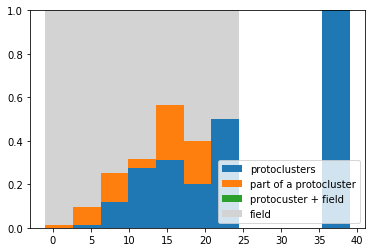

In [179]:
agg_total = np.histogram(dgal, binLimits)[0]

agg_pc = np.histogram(dgal[label==1], binLimits)[0]
agg_pc_field = np.histogram(dgal[label==2], binLimits)[0]
agg_pc_part = np.histogram(dgal[label==3], binLimits)[0]

width = bins[1] - bins[0]

plt.bar(bins, agg_pc / agg_total.astype(float), width=width, label='protoclusters')

plt.bar(bins, agg_pc_part / agg_total.astype(float), 
        width=width, bottom=agg_pc / agg_total.astype(float), label='part of a protocluster') 

plt.bar(bins, agg_pc_field / agg_total.astype(float), width=width, 
        bottom=(agg_pc+agg_pc_part) / agg_total.astype(float), label='protocuster + field')

plt.bar(bins, (agg_total-agg_pc-agg_pc_part-agg_pc_field) / agg_total.astype(float), width=width, 
        bottom=(agg_pc+agg_pc_field+agg_pc_part)/agg_total.astype(float), color='lightgrey', label='field')

# plt.grid()
plt.legend(loc=4)